In [69]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")
# DBSCAN import
from sklearn.cluster import DBSCAN
# Scaler import
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from scipy.stats import zscore


In [2]:
#df  = pd.read_csv('anonymized-curriculum-access.txt', sep= ' ', names=['date', 'time', 'path', 'user_id', 'cohort', 'ip' ])
df = pd.read_table("anonymized-curriculum-access.txt", sep = '\s', header = None, 
                   names = ['date', 'time', 'page', 'id', 'cohort', 'ip'])

df.head()

,date,time,page,id,cohort,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [3]:
df

,date,time,page,id,cohort,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...,...
900218,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33
900219,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33
900220,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33
900221,2021-04-21,16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86


In [68]:
unique_pages = df['page'].unique()
for page in unique_pages:
    print(page)

/
java-ii
java-ii/object-oriented-programming
slides/object_oriented_programming
javascript-i/conditionals
javascript-i/loops
javascript-i/functions
mkdocs/search_index.json
javascript-i/introduction/working-with-data-types-operators-and-variables
javascript-i
javascript-i/introduction/variables
javascript-i/introduction/operators
git/merge-conflict-demo
git/working-in-teams
javascript-i/introduction/primitive-types
javascript-i/javascript-with-html
spring
appendix
spring/extra-features/file-upload
appendix/capstone-workbook
javascript-i/objects/math
index.html
java-i
appendix/further-reading/javascript/hoisting.html
html-css/introduction
javascript-i/bom-and-dom
javascript-i/bom-and-dom/bom
examples/javascript/defuse-the-bom.html
javascript-i/introduction
javascript-i/bom-and-dom/dom
examples/javascript/dom-query-js.html
spring/fundamentals/security/authentication
javascript/primitive-types
appendix/further-reading/javascript/hoisting
mysql
html-css
git/cli
git/branching
spring/fundam

In [70]:
page_views = df.groupby(['cohort', 'page']).size().reset_index(name='views')

# Calculate the proportion of page views for each cohort
cohort_sizes = page_views.groupby('cohort')['views'].sum()
page_views['proportion'] = page_views.apply(lambda row: row.views / cohort_sizes[row.cohort], axis=1)

# Calculate the mean and standard deviation of the proportion of page views for each page across all cohorts
mean_proportions = page_views.groupby('page')['proportion'].mean()
std_proportions = page_views.groupby('page')['proportion'].std()

# Calculate the z-score for each cohort and page
page_views['zscore'] = page_views.apply(lambda row: (row.proportion - mean_proportions[row.page]) / std_proportions[row.page], axis=1)

# Identify any cohort-page pairs with a z-score greater than 2 (i.e., statistically significant)
significant_pairs = page_views[page_views.zscore > 2]

# Print the significant pairs
print(significant_pairs)

       cohort                                               page  views   
62        1.0                       assets/js/pdfmake.min.js.map      9  \
180       1.0                              html-css/css-ii/grids     74   
261       1.0                                      mysql/aliases     49   
344       2.0                      content/git/adding-files.html      1   
345       2.0             content/git/creating-a-repository.html      1   
...       ...                                                ...    ...   
13552   139.0                javascript-i/introduction/variables     95   
13553   139.0  javascript-i/introduction/working-with-data-ty...    146   
13554   139.0                  javascript-i/javascript-with-html    125   
13558   139.0                javascript-i/testing-user-functions     42   
13564   139.0                                                toc    101   

       proportion    zscore  
62       0.001012  2.244791  
180      0.008324  2.107812  
261      

In [4]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df.dtypes

date      datetime64[ns]
time              object
page              object
id                 int64
cohort           float64
ip                object
dtype: object

In [19]:
df['page'].value_counts()

page
/                                                               50313
search/search_index.json                                        19519
javascript-i                                                    18983
toc                                                             18297
java-iii                                                        13733
                                                                ...  
javascript/loops                                                    1
content/control-structures-ii                                       1
javascript-ii/promisesdfghjkjhgfs                                   1
app                                                                 1
appendix/professional-development/post-interview-review-form        1
Name: count, Length: 2313, dtype: int64

In [7]:
df['id'].value_counts().sort_index()


id
1      7404
2      1541
3      1562
4       692
5      1701
       ... 
977      86
978      55
979     127
980       3
981      42
Name: count, Length: 981, dtype: int64

In [9]:
first_access = df.groupby(['id'])['date'].min()
id_by_first_access_date = pd.DataFrame({'first_access_date': first_access}).reset_index().groupby('first_access_date').count()

In [10]:
id_by_first_access_date

,id
first_access_date,
2018-01-26,50
2018-01-27,2
2018-01-28,2
2018-01-29,12
2018-01-30,7
...,...
2021-04-08,1
2021-04-11,1
2021-04-12,26


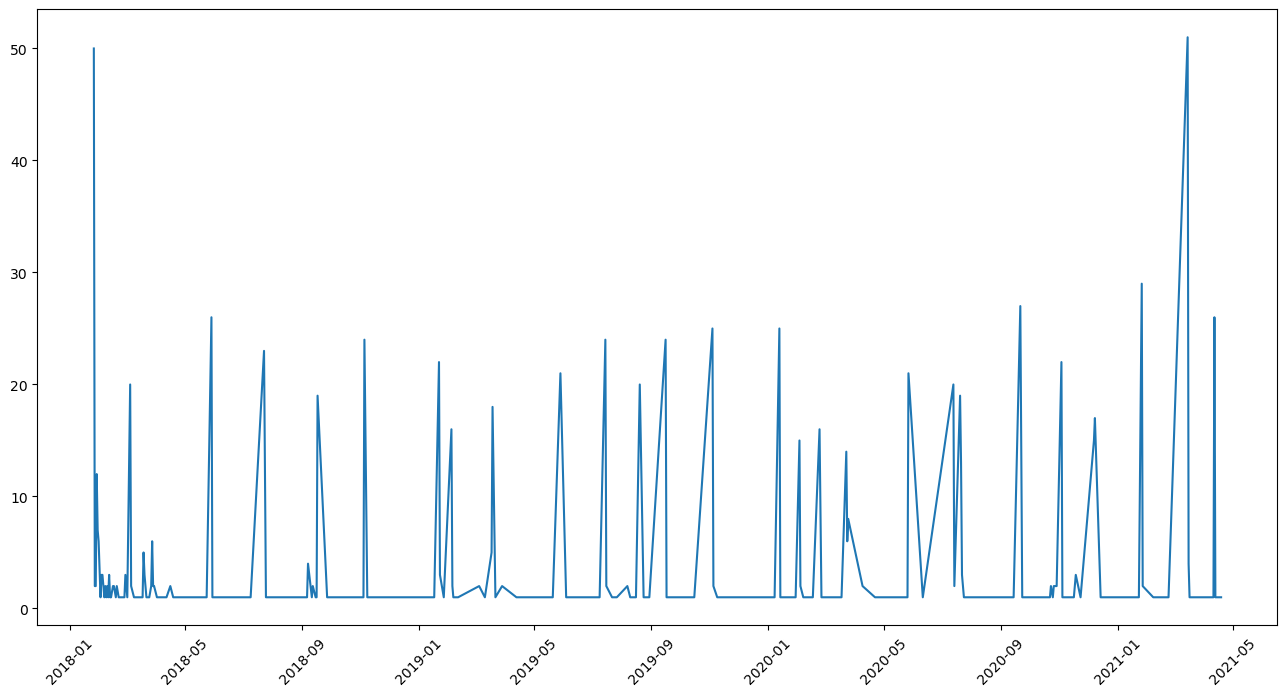

In [11]:
fig = plt.figure(figsize=(16, 8))
plt.plot(id_by_first_access_date)
plt.xticks(rotation = 45)
plt.show()

In [35]:
id_by_first_access_date = pd.DataFrame({'first_access_date': first_access}).reset_index()
id_by_first_access_date

,id,first_access_date
0,1,2018-01-26
1,2,2018-01-26
2,3,2018-01-26
3,4,2018-01-26
4,5,2018-01-26
...,...,...
976,977,2021-04-12
977,978,2021-04-12
978,979,2021-04-12
979,980,2021-04-13


In [36]:
id_by_first_access_date = id_by_first_access_date.groupby('first_access_date').count()\
.rename(columns={'id':'count_of_unique_ids'})
id_by_first_access_date

,count_of_unique_ids
first_access_date,
2018-01-26,50
2018-01-27,2
2018-01-28,2
2018-01-29,12
2018-01-30,7
...,...
2021-04-08,1
2021-04-11,1
2021-04-12,26


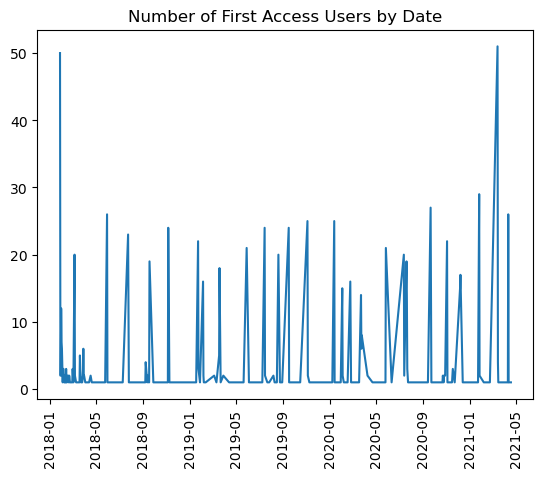

In [38]:
plt.plot(id_by_first_access_date)
plt.xticks(rotation=90)
plt.title('Number of First Access Users by Date')
plt.show()

In [39]:
df_2019 = df[df["date"].dt.year == 2019]
df_2019

,date,time,page,id,cohort,ip
175808,2019-01-01,07:45:45,java-iii/mvc,271,26.0,73.31.215.224
175809,2019-01-01,12:20:53,/,51,13.0,72.179.161.39
175810,2019-01-01,12:56:12,java-i,274,26.0,67.11.239.2
175811,2019-01-01,12:59:46,java-i/strings,274,26.0,67.11.239.2
175812,2019-01-01,15:25:49,java-i/methods,274,26.0,67.11.239.2
...,...,...,...,...,...,...
421906,2019-12-31,15:44:41,java-iii/user-input,514,28.0,67.11.193.143
421907,2019-12-31,15:44:41,java-iii/passwords,514,28.0,67.11.193.143
421908,2019-12-31,17:41:42,java-i,490,51.0,189.140.49.80
421909,2019-12-31,17:41:44,java-i/console-io,490,51.0,189.140.49.80


<AxesSubplot:ylabel='Count'>

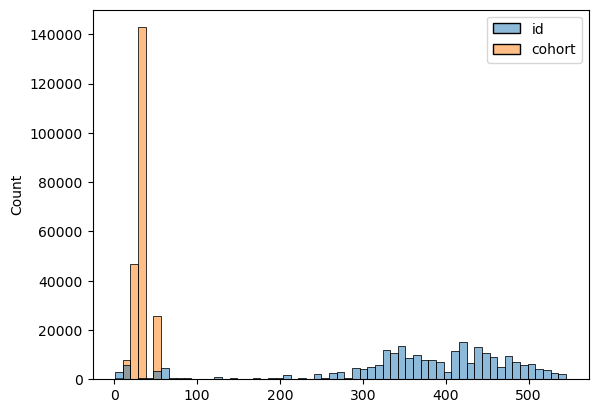

In [41]:
sns.histplot(df_2019)

In [46]:
df_grouped = df.groupby(['date', 'cohort', 'page']).size().reset_index(name='views')
df_grouped

,date,cohort,page,views
0,2018-01-26,1.0,/,3
1,2018-01-26,1.0,appendix,1
2,2018-01-26,1.0,appendix/capstone-workbook,1
3,2018-01-26,1.0,appendix/further-reading/javascript/hoisting,1
4,2018-01-26,1.0,appendix/further-reading/javascript/hoisting.html,1
...,...,...,...,...
231630,2021-04-21,139.0,javascript-i/javascript-with-html,9
231631,2021-04-21,139.0,javascript-i/loops,2
231632,2021-04-21,139.0,javascript-i/testing-user-functions,6
231633,2021-04-21,139.0,search/search_index.json,2


In [48]:
df_grouped_1 = df_grouped.groupby(['cohort', 'page']).agg({'views': 'sum'}).reset_index()
df_grouped_1

,cohort,page,views
0,1.0,/,626
1,1.0,0_Classification_Algorithms,1
2,1.0,2.0_Intro_Stats,1
3,1.0,5.0_Intro_Regression,2
4,1.0,7.0_Intro_Clustering,2
...,...,...,...
13560,139.0,jquery,4
13561,139.0,jquery/essential-methods/attributes-and-css,1
13562,139.0,search/search_index.json,9
13563,139.0,spring,2


In [50]:
df_sorted = df_grouped_1.sort_values(['cohort', 'views'], ascending=[True, False])
df_sorted

,cohort,page,views
0,1.0,/,626
213,1.0,javascript-i,294
170,1.0,html-css,215
235,1.0,javascript-ii,204
323,1.0,spring,192
...,...,...,...
13540,139.0,java-iii/servlets,1
13545,139.0,javascript-i/bom-and-dom/dom,1
13556,139.0,javascript-i/objects,1
13557,139.0,javascript-i/objects/math,1


In [57]:
df_filtered = df_sorted[df_sorted['page'] != "/"]
df_filtered

,cohort,page,views
213,1.0,javascript-i,294
170,1.0,html-css,215
235,1.0,javascript-ii,204
323,1.0,spring,192
194,1.0,java-ii,167
...,...,...,...
13540,139.0,java-iii/servlets,1
13545,139.0,javascript-i/bom-and-dom/dom,1
13556,139.0,javascript-i/objects,1
13557,139.0,javascript-i/objects/math,1


In [85]:
df_filtered3 = df_filtered.drop(df_filtered.cohort).sort_values(['views'])


AttributeError: 'DataFrame' object has no attribute 'cohort'

In [59]:
for cohort in df_filtered['cohort'].unique():
    top_page = df_filtered.loc[df_filtered['cohort'] == cohort, 'page'].iloc[0]
    top_views = df_filtered.loc[df_filtered['cohort'] == cohort, 'views'].iloc[0]
    print(f"For cohort {cohort}, the most viewed page is {top_page} with {top_views} views.")


For cohort 1.0, the most viewed page is javascript-i with 294 views.
For cohort 2.0, the most viewed page is content/php_ii/command-line with 6 views.
For cohort 4.0, the most viewed page is mkdocs/search_index.json with 1 views.
For cohort 6.0, the most viewed page is javascript-ii/es6 with 10 views.
For cohort 7.0, the most viewed page is content/html-css with 29 views.
For cohort 8.0, the most viewed page is java-iii with 57 views.
For cohort 9.0, the most viewed page is content/html-css with 2 views.
For cohort 11.0, the most viewed page is html-css with 12 views.
For cohort 12.0, the most viewed page is content/html-css with 19 views.
For cohort 13.0, the most viewed page is index.html with 84 views.
For cohort 14.0, the most viewed page is index.html with 877 views.
For cohort 15.0, the most viewed page is java-i with 19 views.
For cohort 16.0, the most viewed page is spring with 65 views.
For cohort 17.0, the most viewed page is javascript-i with 128 views.
For cohort 18.0, the 

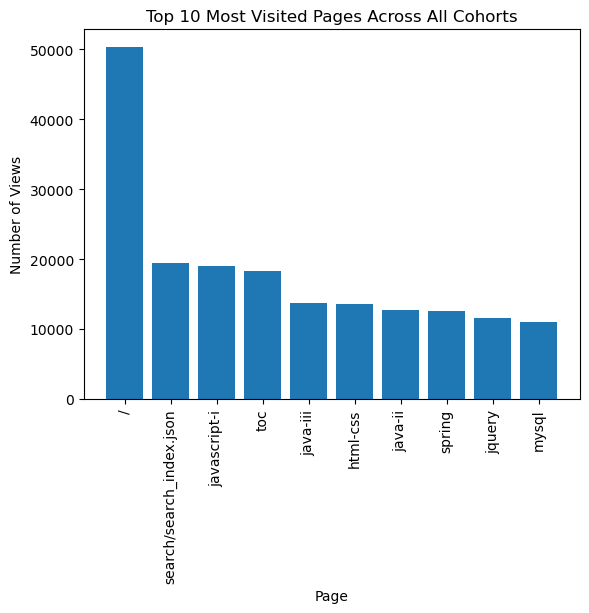

In [60]:
df_filtered = df.groupby('page').size().reset_index(name='views')

# Sort the data in descending order by the number of views
df_filtered1 = df_filtered.sort_values('views', ascending=False)

# Get the top 10 pages by number of views
top_pages = df_filtered1.head(10)

# Create a bar plot showing the number of views for each page
plt.bar(top_pages['page'], top_pages['views'])

# Set the title and axis labels
plt.title('Top 10 Most Visited Pages Across All Cohorts')
plt.xlabel('Page')
plt.ylabel('Number of Views')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()

## Timeframe for Each Cohort

In [96]:
cohort_timeframes = df.groupby('cohort')['date'].agg(['min', 'max'])
cohort_timeframes

,min,max
cohort,,
1.0,2018-01-26,2021-02-09
2.0,2018-03-19,2019-07-31
4.0,2018-02-04,2018-02-04
5.0,2020-05-06,2020-05-06
6.0,2018-10-16,2019-05-12
7.0,2018-01-31,2021-03-01
8.0,2018-01-26,2020-04-28
9.0,2018-03-22,2018-03-22
11.0,2018-05-07,2020-12-10


In [101]:

Q1 = df['date'].quantile(0.25)
Q3 = df['date'].quantile(0.75)
IQR = Q3 - Q1
timed_df = df[(df['date'] >= Q1 - 1.5*IQR) & (df['date'] <= Q3 + 1.5*IQR)]
cohort_timeframes = timed_df.groupby('cohort')['date'].agg(['min', 'max'])
cohort_timeframes

,min,max
cohort,,
1.0,2018-01-26,2021-02-09
2.0,2018-03-19,2019-07-31
4.0,2018-02-04,2018-02-04
5.0,2020-05-06,2020-05-06
6.0,2018-10-16,2019-05-12
7.0,2018-01-31,2021-03-01
8.0,2018-01-26,2020-04-28
9.0,2018-03-22,2018-03-22
11.0,2018-05-07,2020-12-10


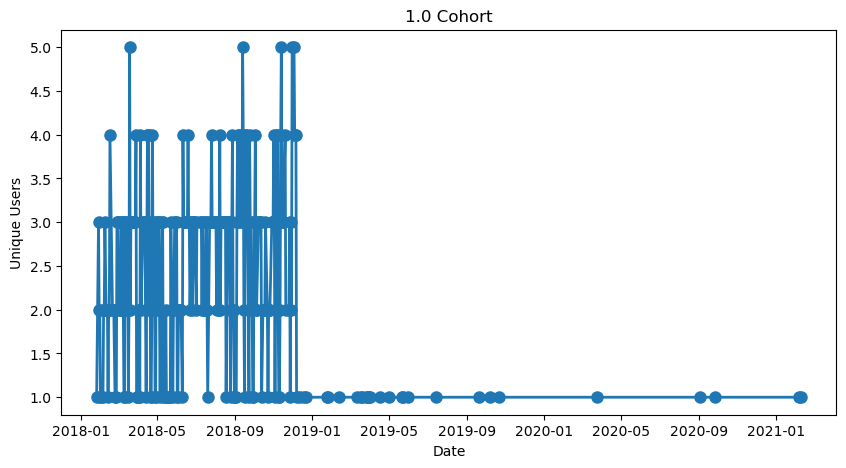

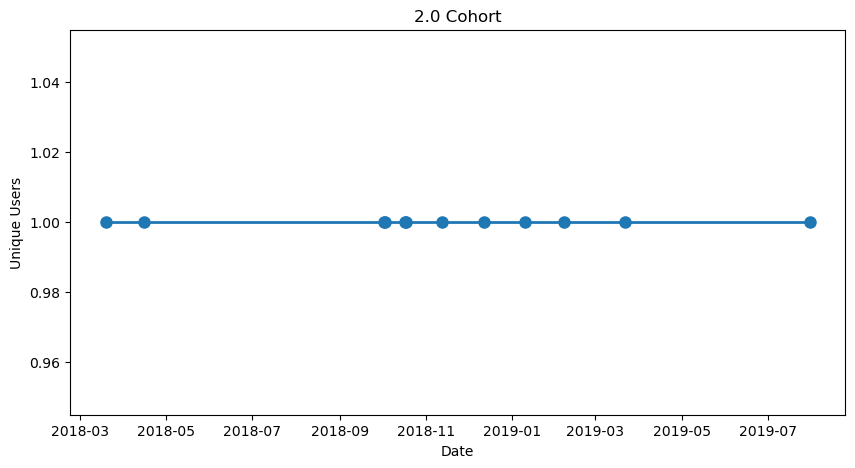

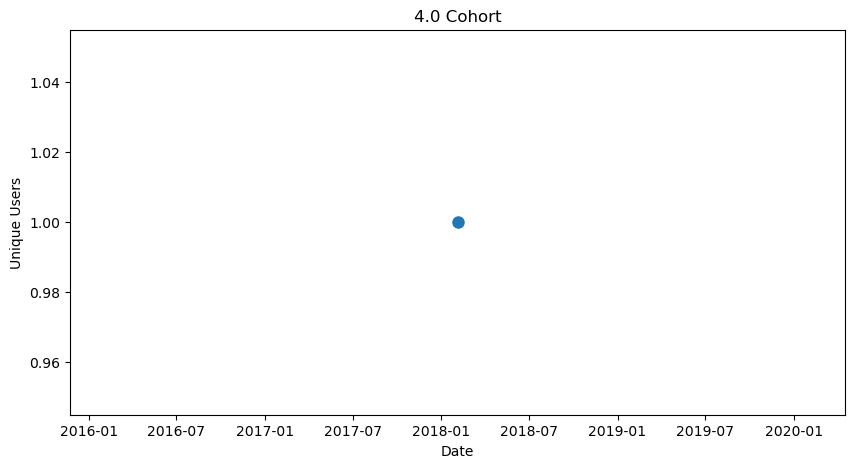

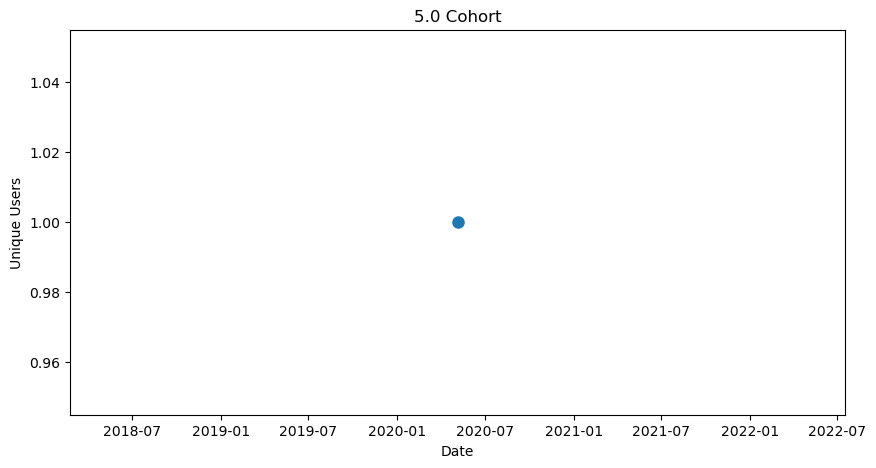

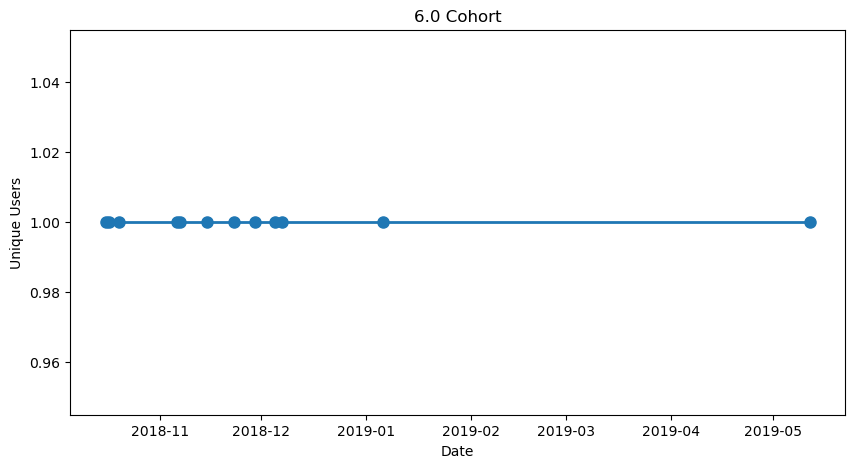

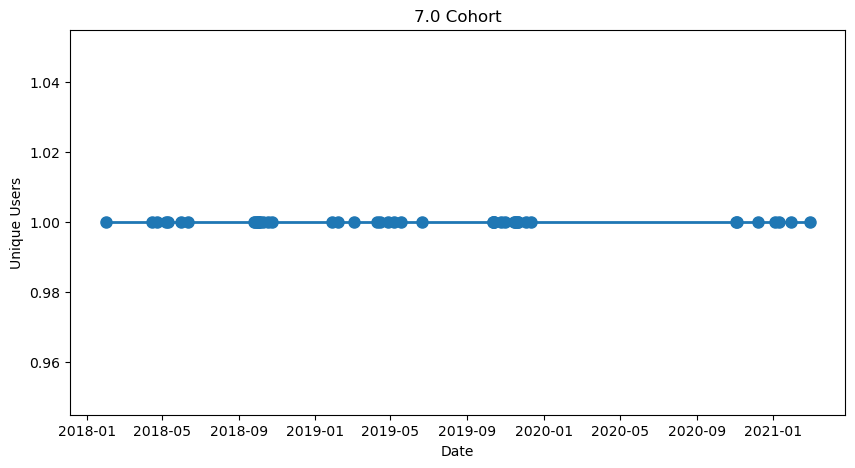

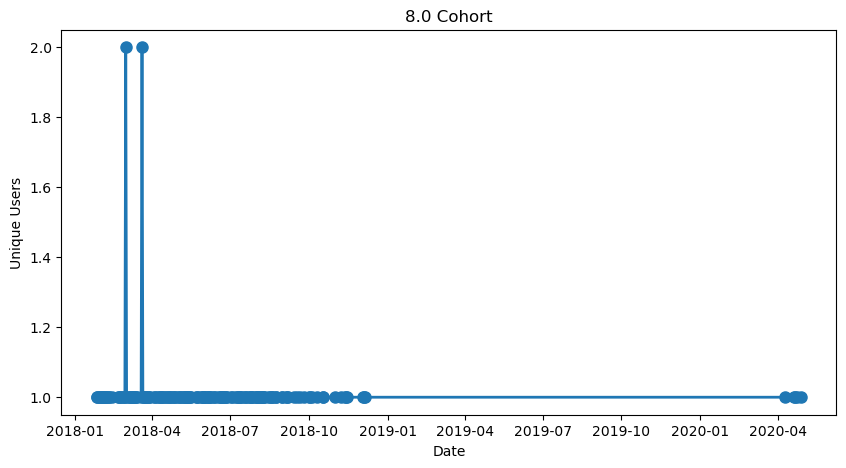

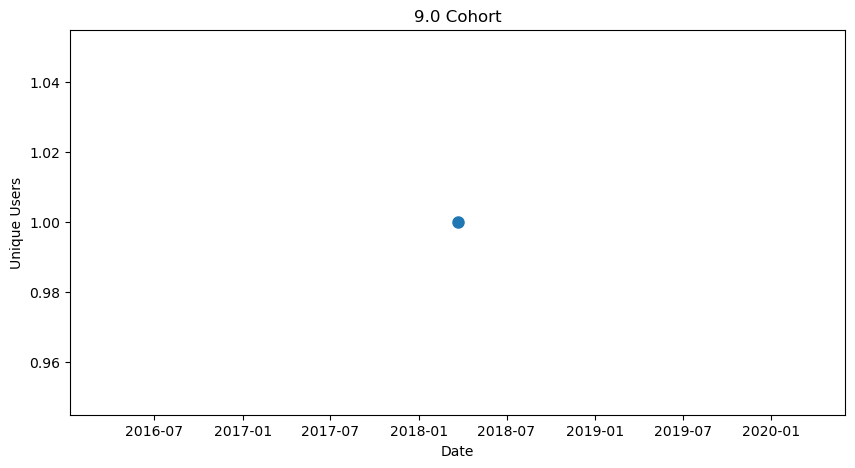

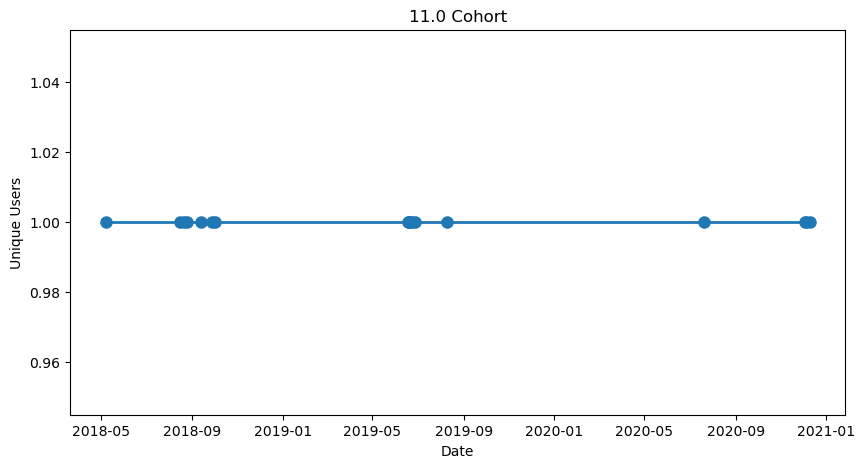

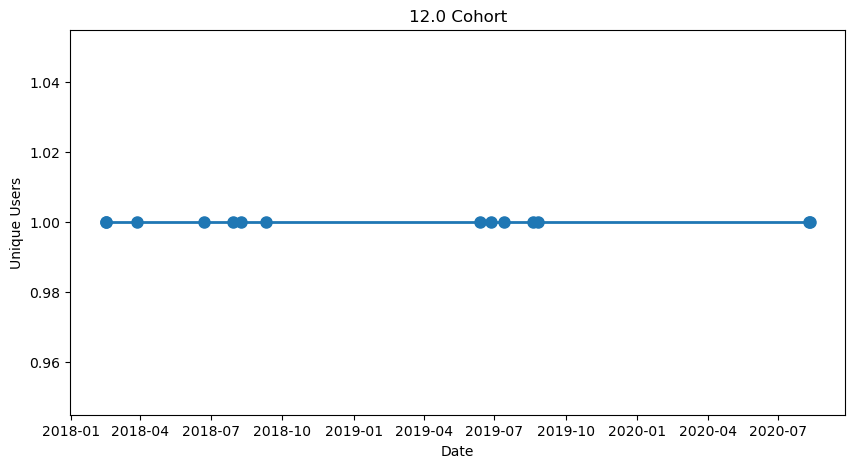

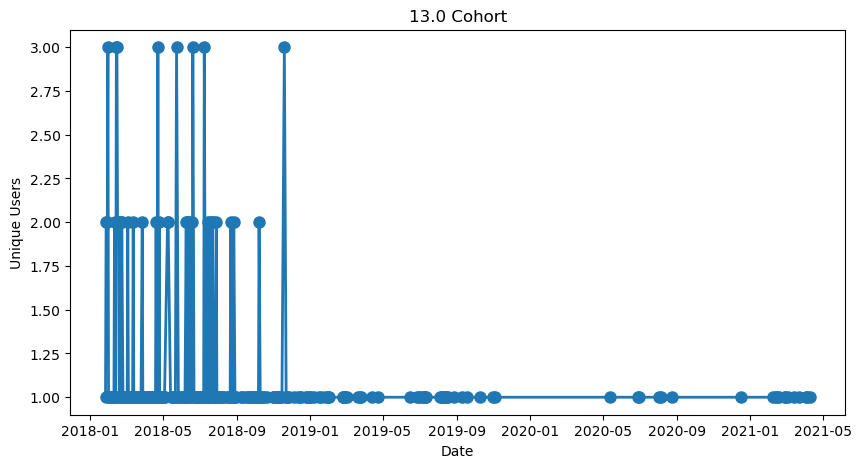

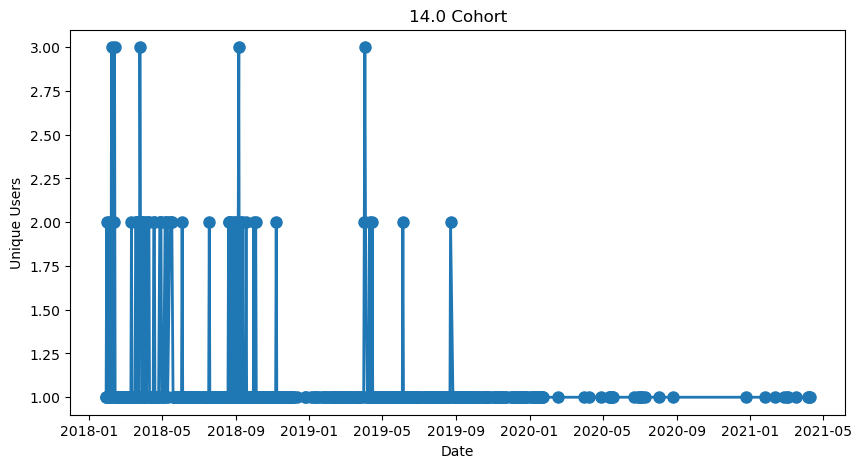

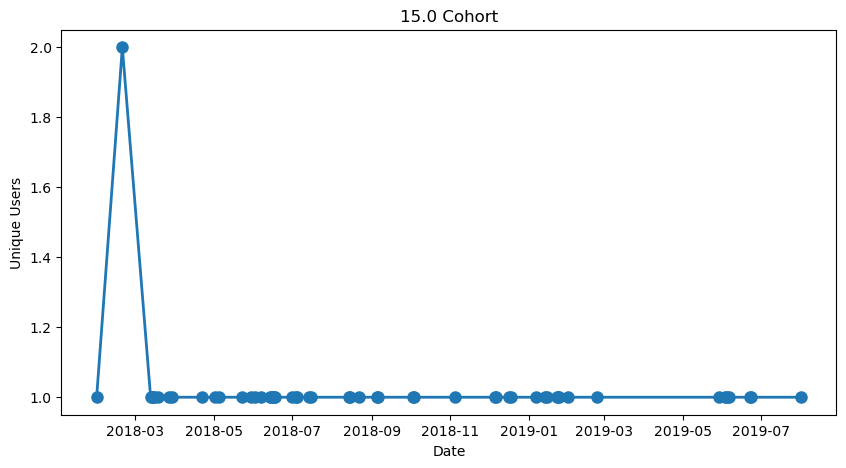

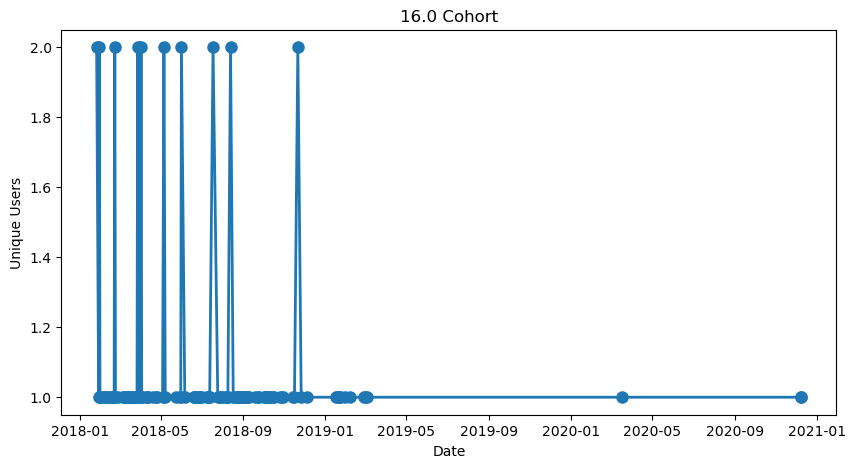

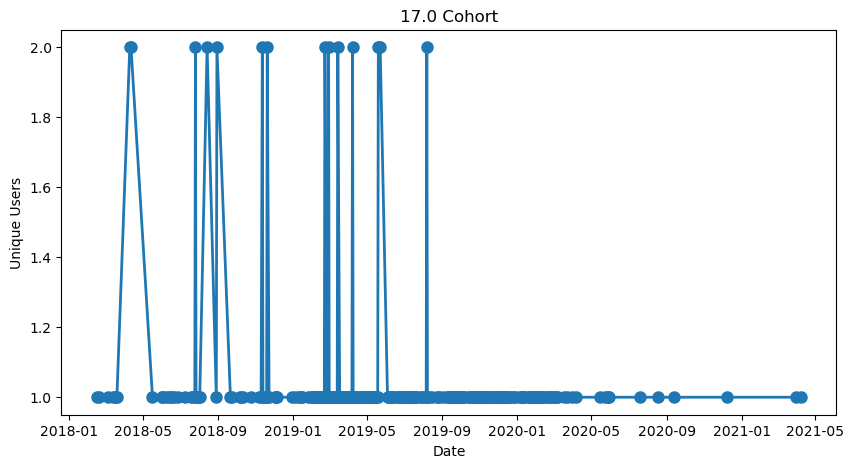

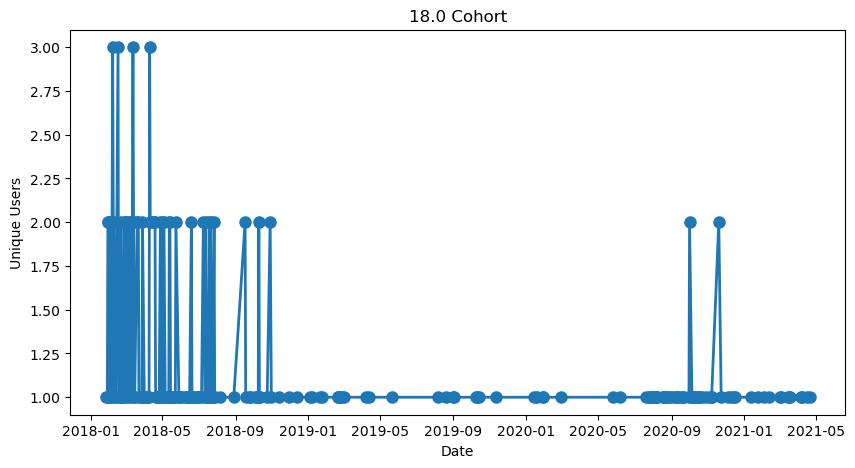

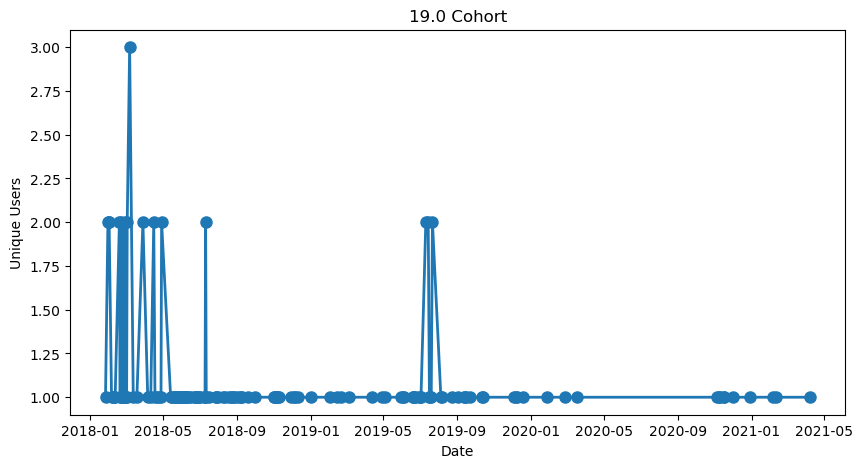

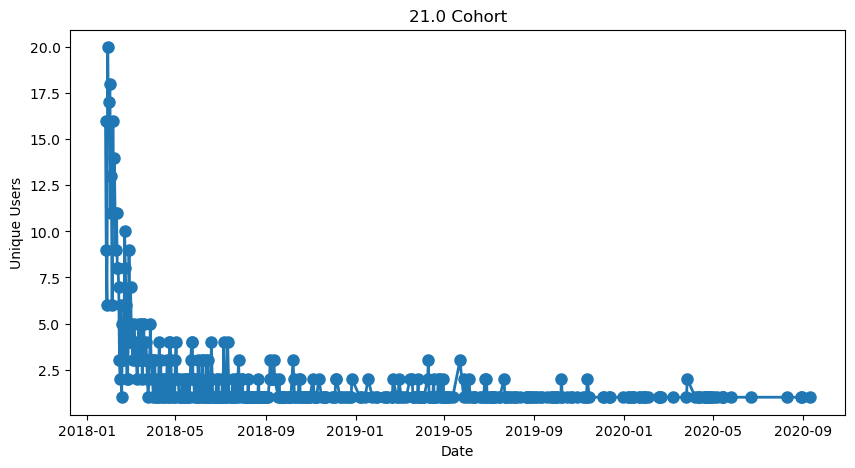

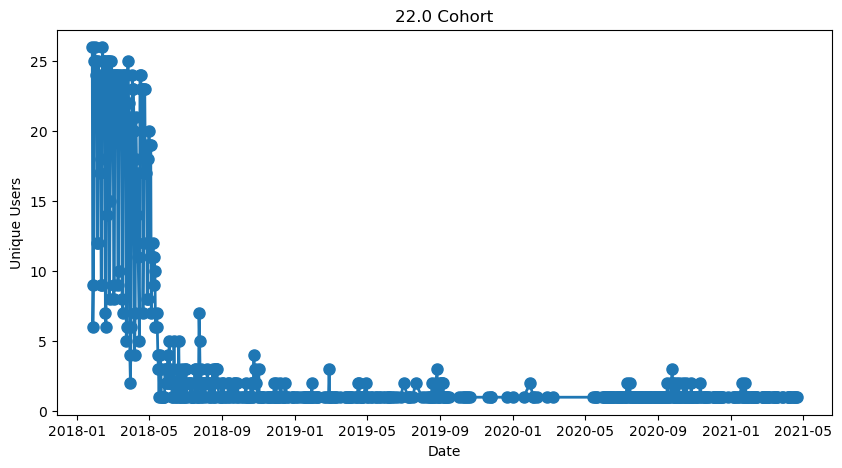

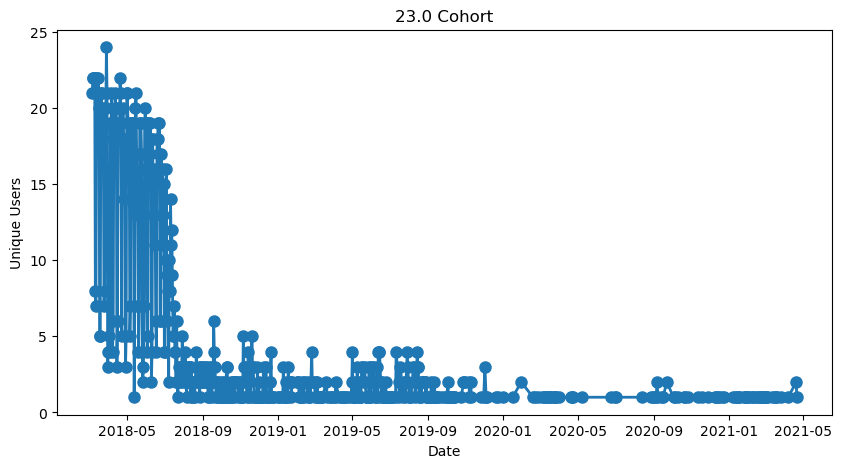

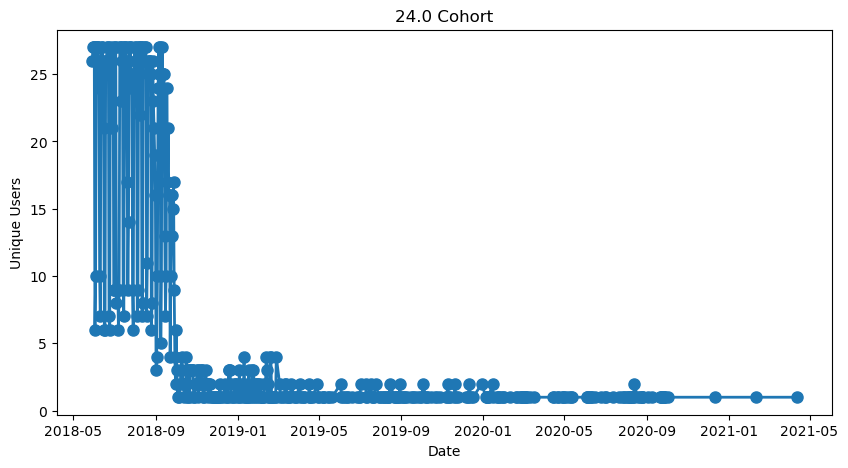

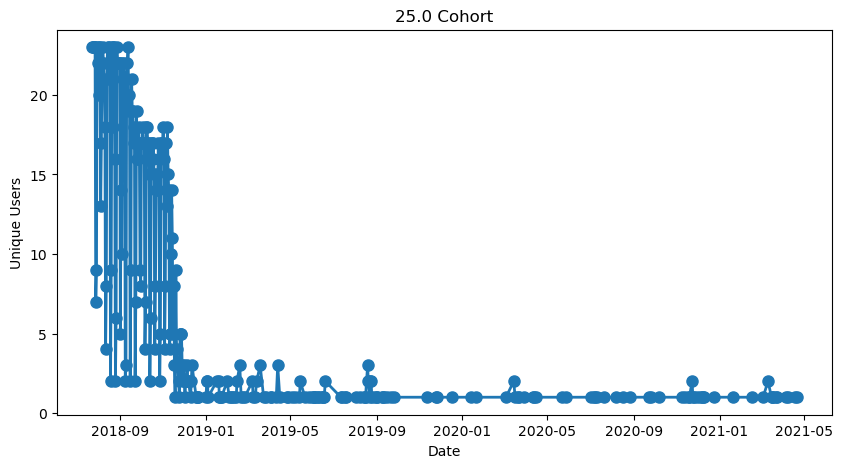

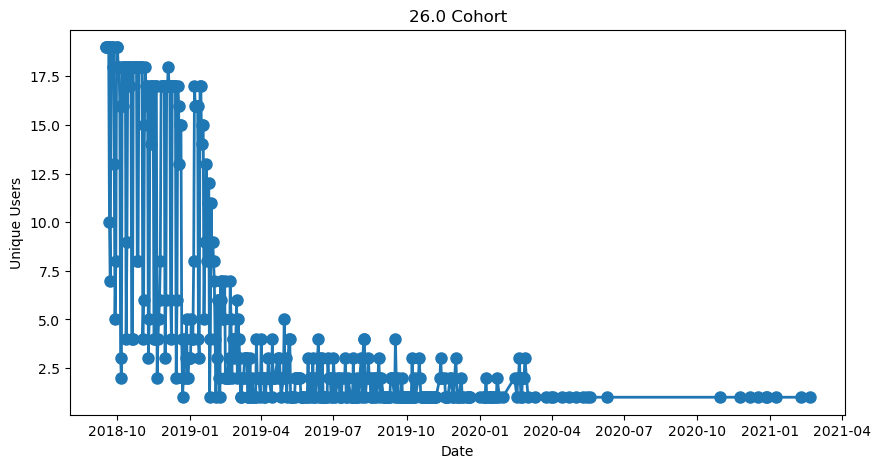

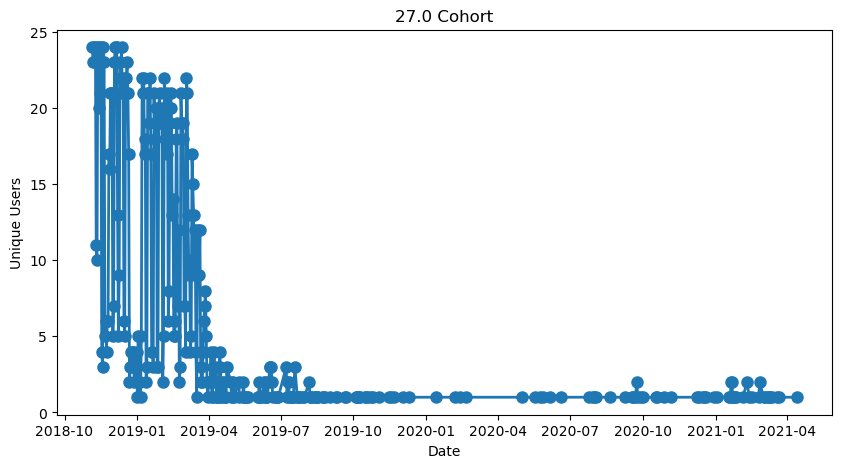

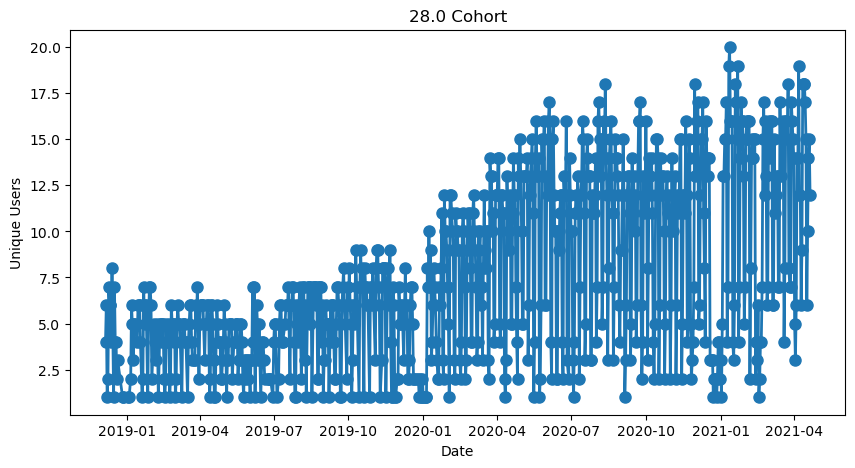

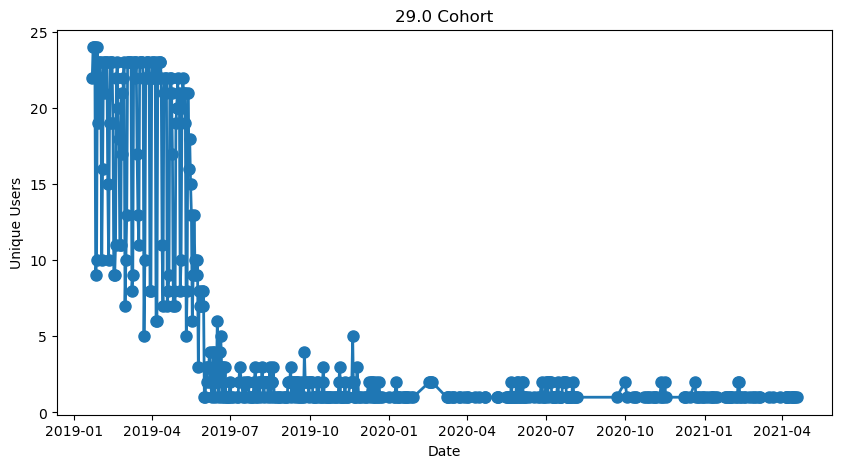

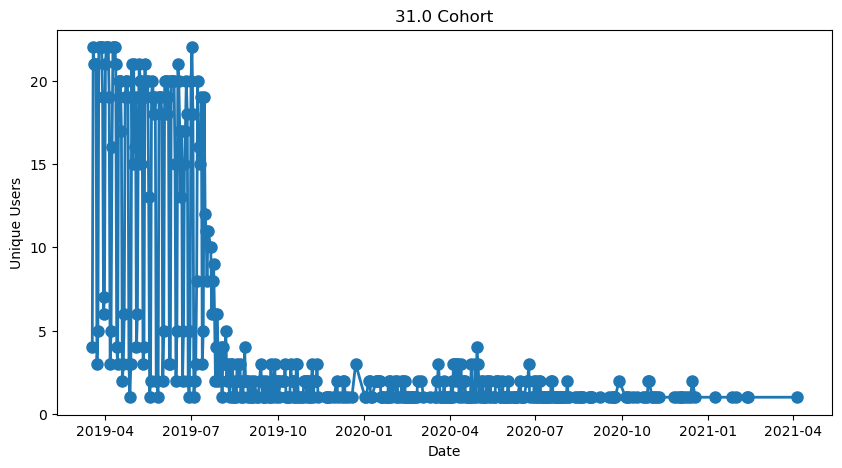

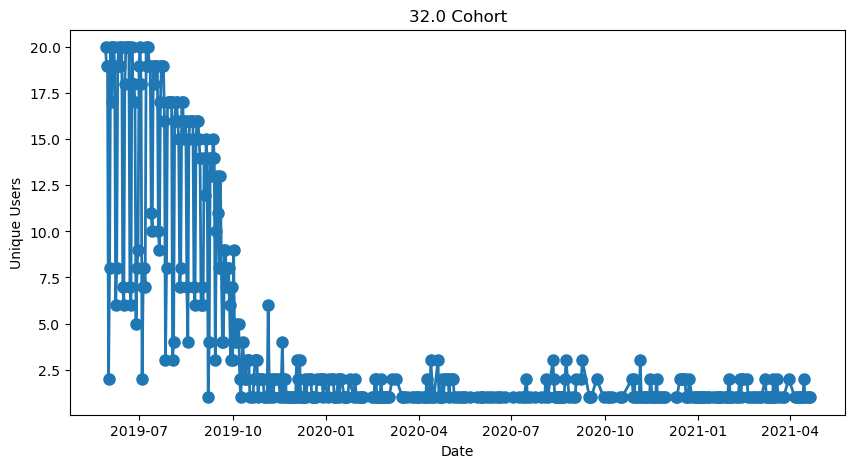

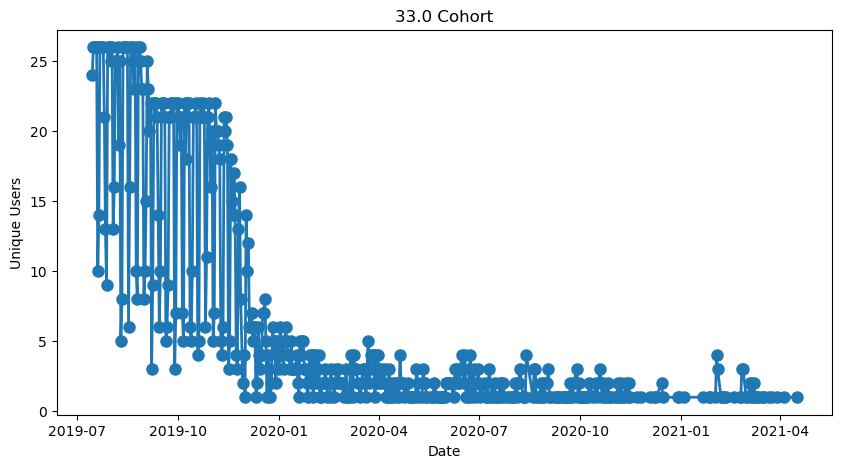

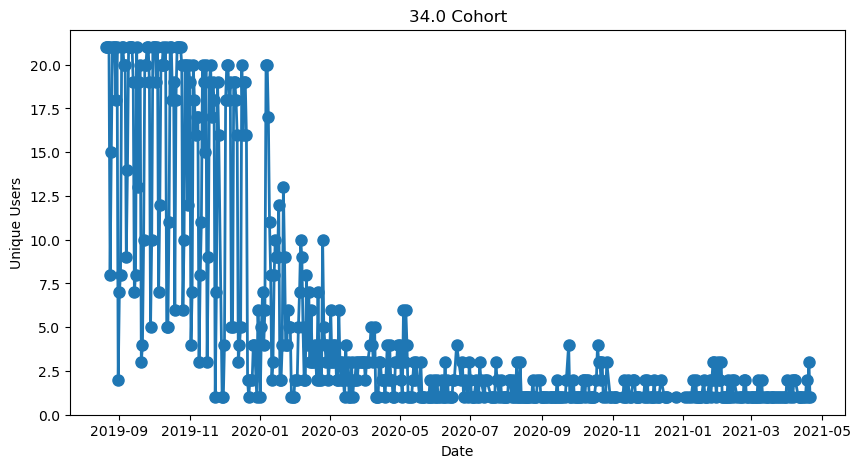

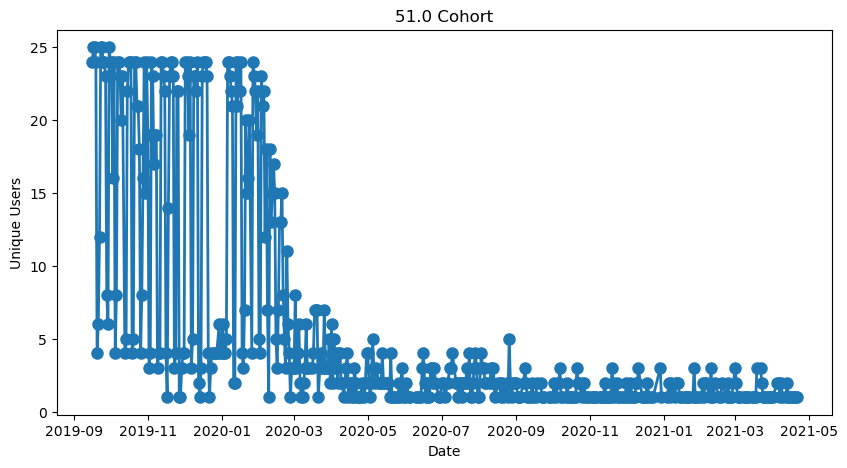

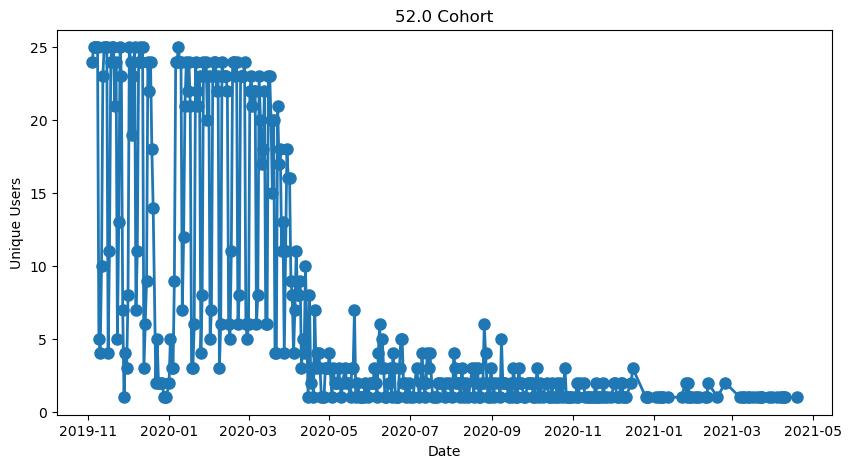

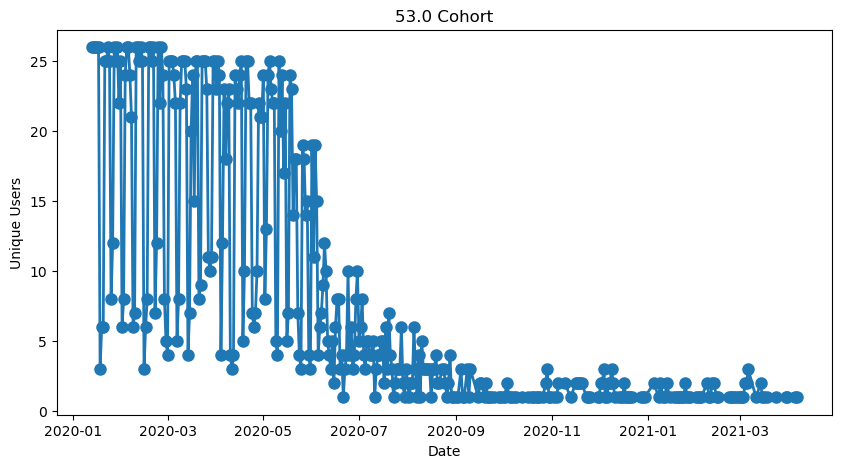

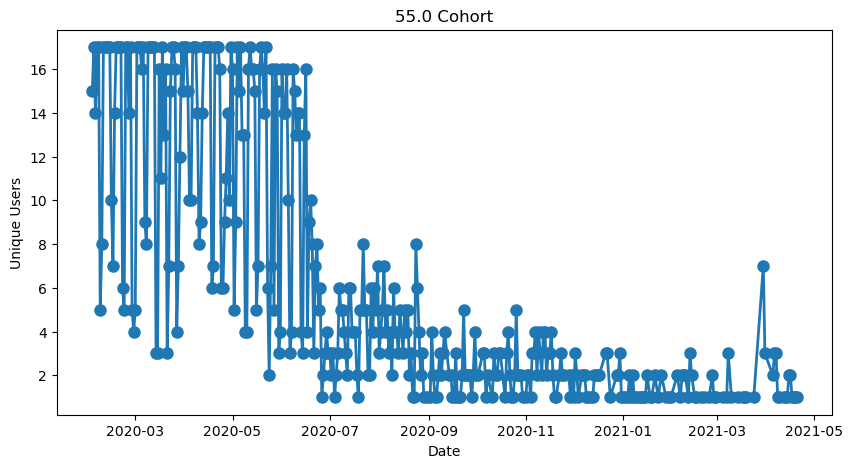

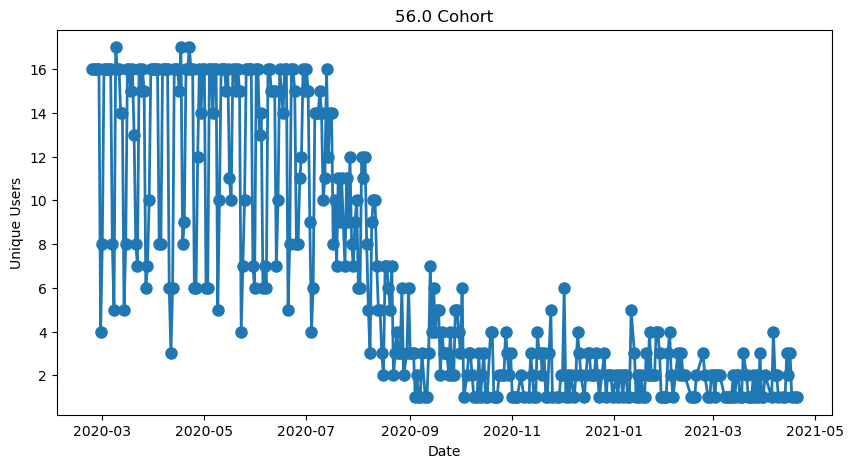

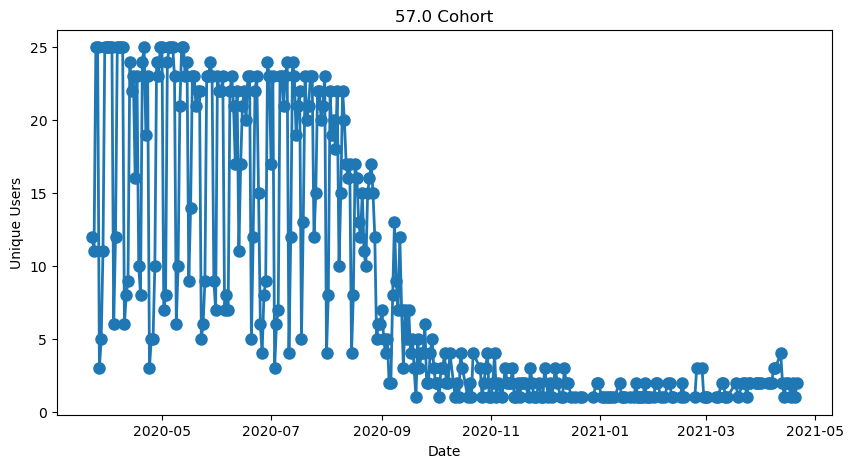

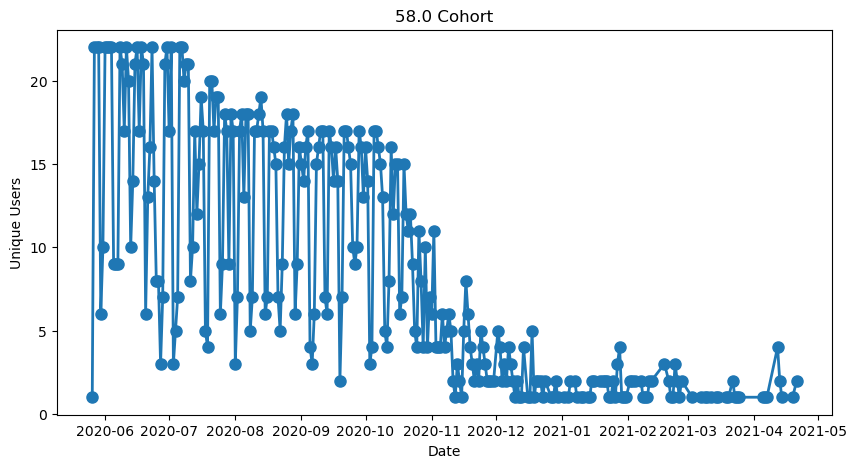

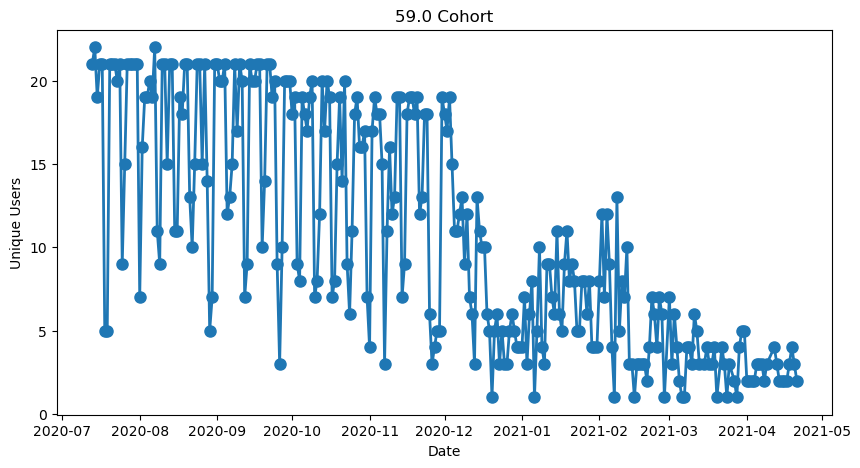

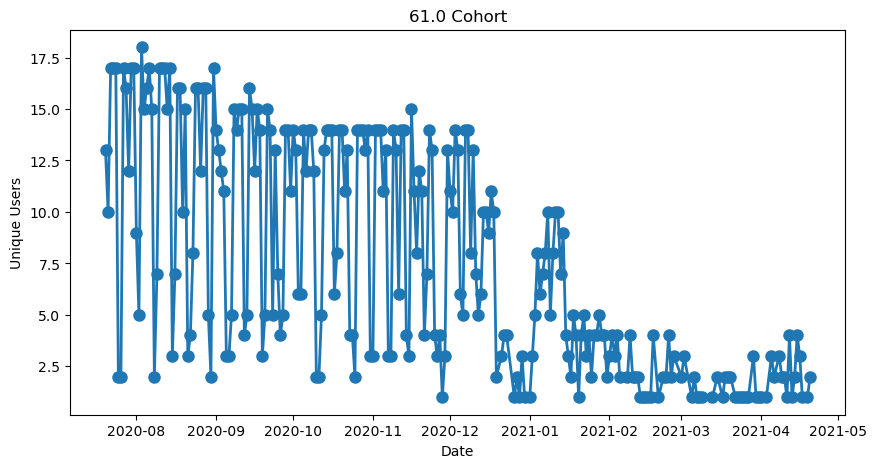

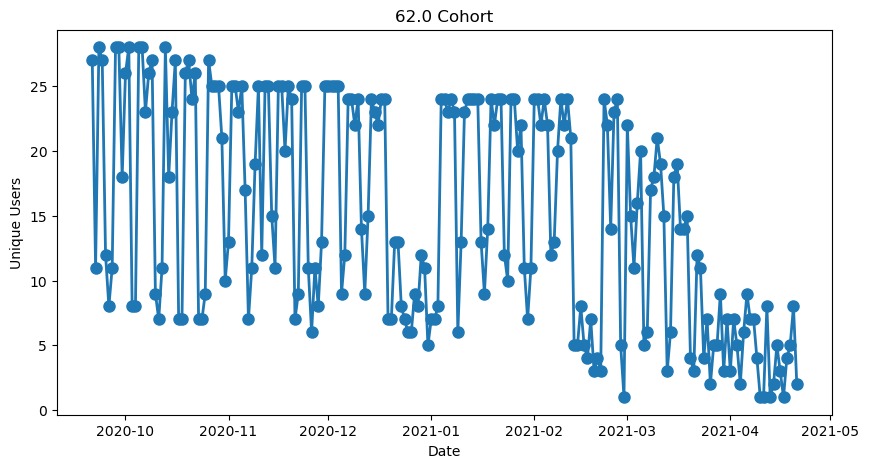

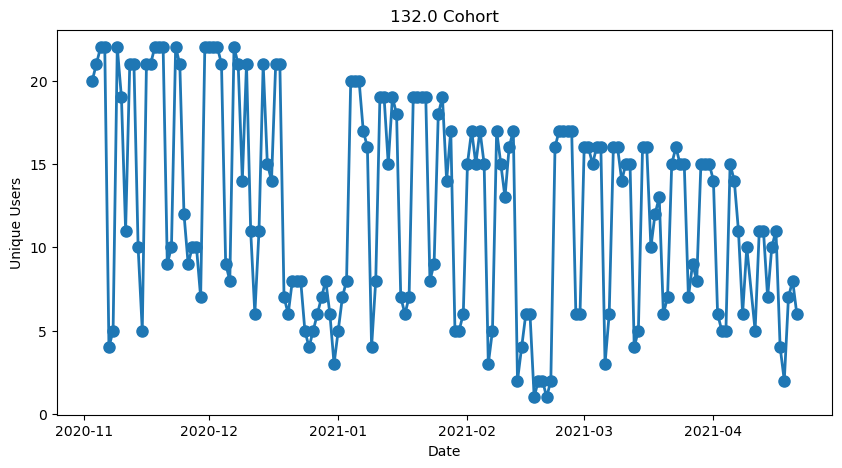

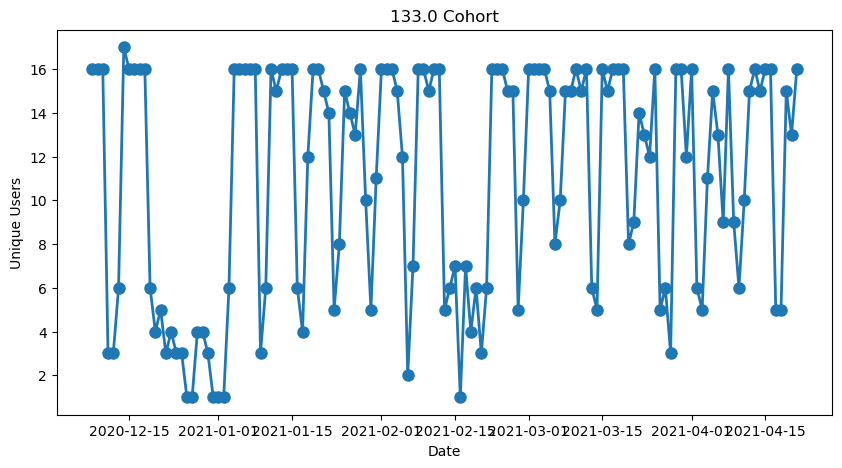

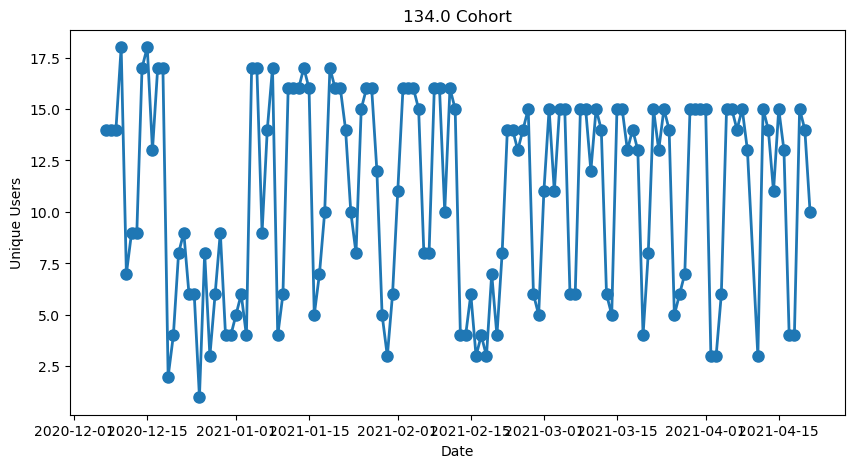

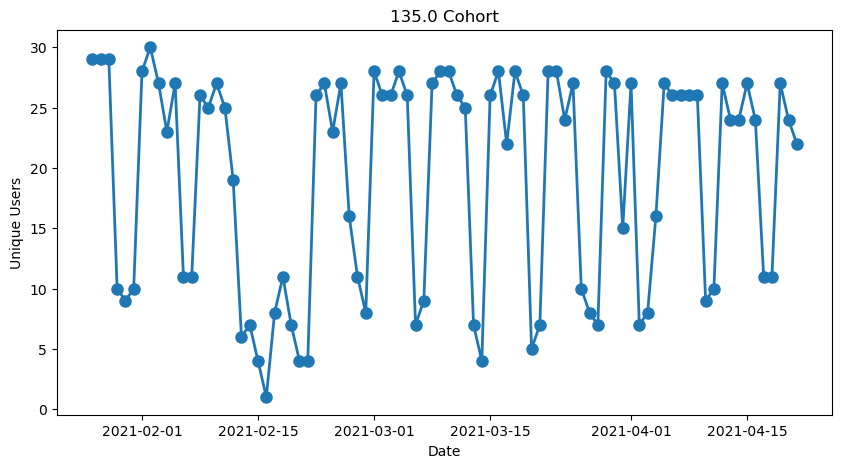

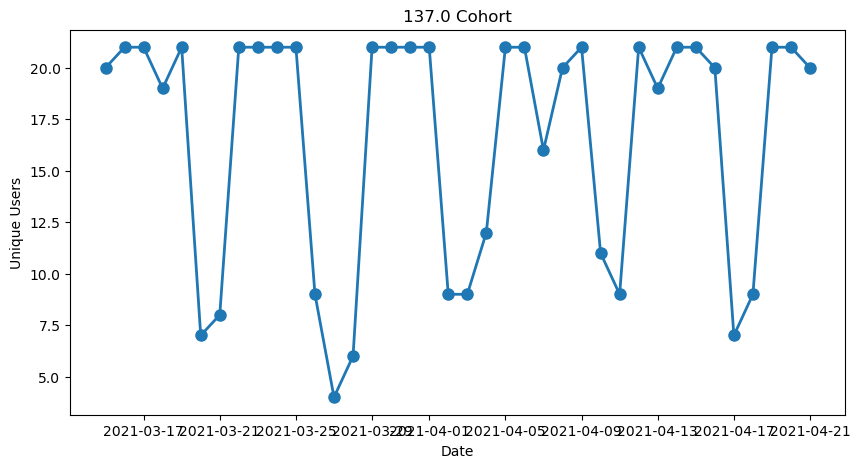

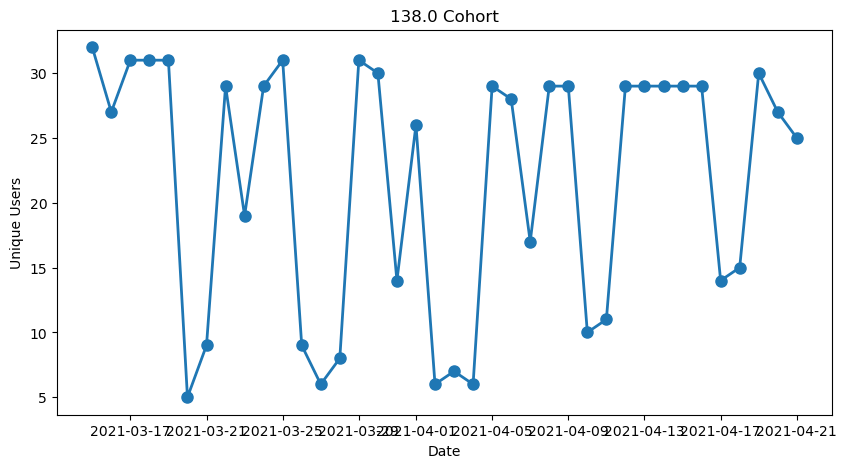

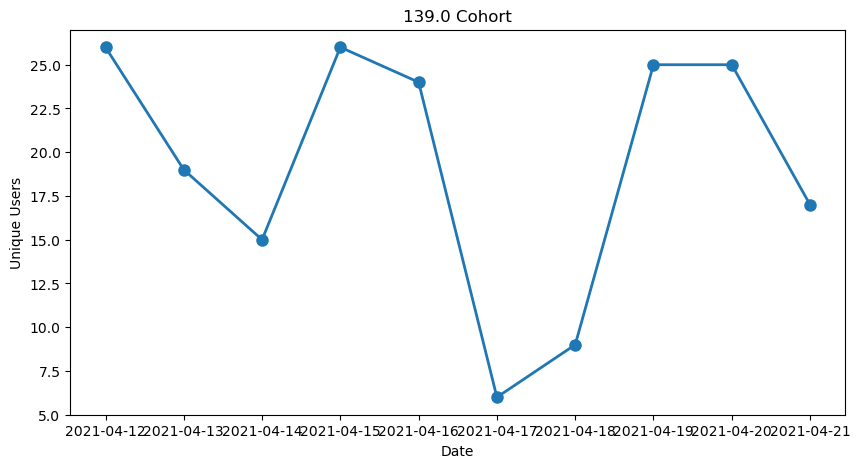

In [102]:
for cohort, cohort_df in df.groupby('cohort'):

    # Count the number of unique users for each day
    cohort_counts = cohort_df.groupby('date')['id'].nunique()

    # Create a line plot of the daily user counts
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(cohort_counts.index, cohort_counts.values, '-o', linewidth=2, markersize=8)

    # Set chart title and axis labels
    ax.set_title(f'{cohort} Cohort')
    ax.set_xlabel('Date')
    ax.set_ylabel('Unique Users')

    plt.show()

## Lessons Least Accessed

In [90]:
df_sorted2 = df_sorted.drop('cohort', axis=1)

# sort by "views" in descending order
df22 = df_sorted2.sort_values('views', ascending=False)

# show only the rows with 1 view
df22 = df22[df22['views'] == 1]


In [91]:
df22

,page,views
1052,content/php_iv/php-with-mysql/query-and-result...,1
5977,10-nlp/exercises,1
5962,10-anomaly-detection/3-discrete-probabilistic-...,1
5968,10-anomaly-detection/isolation-forests,1
5970,10-anomaly-detection/time-series-anomaly-detec...,1
...,...,...
8950,appendix/git/cli,1
8943,appendix/coding-challenges/amateur,1
8942,appendix/coding-challenges,1
8941,appendix/cls/2-listing-files,1


In [94]:
unique_pages = df22['page'].unique()
for page in unique_pages:
    print(page)
    print( )

content/php_iv/php-with-mysql/query-and-results.html

10-nlp/exercises

10-anomaly-detection/3-discrete-probabilistic-methods.ipynb

10-anomaly-detection/isolation-forests

10-anomaly-detection/time-series-anomaly-detection-part-3

10-nlp/2-regular-expressions

10-nlp/3-acquire

10.00_Intro

10-anomaly-detection/2-continuous-probabilistic-methods.ipynb

10.10_Exercises

10_Appendix_EntityLabeling

content/html-css/introduction.html

content/html-css/gitbook/images/favicon.ico

/

11-distributed-ml/3-getting-started

10-anomaly-detection/2-continuous-probabilistic-methods.md

1._Fundamentals/index.html

mysql/functions

00_

'

content/javascript_ii/map-filter-reduce.html

content/jquery

content/jquery/gitbook/images/favicon.ico

content/php_i/intro-to-operators

content/php_i/intro-to-operators/arithmetic-operators.html

content/php_i/intro-to-operators/assignment-operators.html

content/php_i/intro-to-operators/comparison-operators.html

content/php_i/intro-to-operators/gitbook/image